In [375]:
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy
from scipy.special import gamma
from scipy.special import beta
import scipy.integrate as integrate

In [300]:
def genParam(n, randomstate) :
    r = np.random.RandomState(seed=randomstate)
    
    alpha = r.exponential(1,(n,3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1,n) :
      betai = [r.dirichlet(alpha[i])]
      beta = np.concatenate((beta,betai), axis=0)
    
    mu = [[beta[0][0]-beta[0][1], 2*(beta[0][0]+beta[0][1])-1]]
    for i in range(1,n) :
      mui = [[beta[i][0]-beta[i][1], 2*(beta[i][0]+beta[i][1])-1]]
      mu = np.concatenate((mu, mui),axis=0)
    sigma = r.wald(ksi[0], ksi[1],n)
    
    return(alpha, ksi, beta, mu, sigma)

In [301]:
def genX(n, T, mu, sigma) :
    A = np.eye(T, T+2) + mu[0][0]*np.eye(T, T+2,1) + mu[0][1]*np.eye(T, T+2,2)
    A = A@A.T
    X = [np.random.multivariate_normal(np.zeros(T), sigma[0]*A)]
    for i in range(1,n) :
      A = np.eye(T, T+2) + mu[i][0]*np.eye(T, T+2,1) + mu[i][1]*np.eye(T, T+2,2)
      A = sigma[i]*A@A.T
      Xi = [np.random.multivariate_normal(np.zeros(T), A)]
      X = np.concatenate((X,Xi), axis=0)
    return(X)

In [374]:
def MH(N, n, T, randomstate) :
    
    time0 = time.time()
    
    #Génération des données observées
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    X = genX(n, T, mu, sigma)
    
    #Génération de l'état initial
    ksiMH = [np.abs(np.random.standard_cauchy(2))]
    sigmaMH = [np.random.wald(ksiMH[0][0], ksiMH[0][1], n)]
    
    #Génération de la chaîne de Markov
    for i in range(N) :
        L = 1
    
        #Génération des propositions
        ksiMHprop = [np.random.exponential(scale=ksiMH[i][0]), np.random.exponential(scale=ksiMH[i][1])]
        sigmaMHprop = []
        for k in range(n) :
            sigmaMHprop.append(np.random.exponential(scale=sigmaMH[i][k]))
        Lprop = 1
        
        for j in range(n):
    
            AMH = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMH = sigmaMH[i][j]*(AMH@AMH.T)
    
            L = L*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMH)
            L = L*scipy.stats.invgauss.pdf(sigmaMH[i][j], mu=ksiMH[i][0]/ksiMH[i][1], loc=0, scale=ksiMH[i][1])
    
            AMHprop = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMHprop = sigmaMHprop[j]*(AMHprop@AMHprop.T)
                
            Lprop = Lprop*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMHprop)
            Lprop = Lprop*scipy.stats.invgauss.pdf(sigmaMHprop[j], mu=ksiMHprop[0]/ksiMHprop[1], loc=0, scale=ksiMHprop[1])
    
        L = L*scipy.stats.halfcauchy.pdf(ksiMH[i][0])*scipy.stats.halfcauchy.pdf(ksiMH[i][1])
        Lprop = Lprop*scipy.stats.halfcauchy.pdf(ksiMHprop[0])*scipy.stats.halfcauchy.pdf(ksiMHprop[1])
    
        num = 1
        den = 1
        for k in range(n) :
            num = num*scipy.stats.expon.pdf(sigmaMH[i][k], scale=sigmaMHprop[k])
            den = den*scipy.stats.expon.pdf(sigmaMHprop[k], scale=sigmaMH[i][k])
        num = num*scipy.stats.expon.pdf(ksiMH[i][0], scale=ksiMHprop[0])*scipy.stats.expon.pdf(ksiMH[i][1], scale=ksiMHprop[1])
        den = den*(scipy.stats.expon.pdf(ksiMHprop[0], scale=ksiMH[i][0])*scipy.stats.expon.pdf(ksiMHprop[1], scale=ksiMH[i][1]))
        num = num*Lprop
        den = den*L
        if den == 0 :  
            ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
            sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
            #ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
            #sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
        else :
            r = min(1, num/den)
            if np.random.uniform() <= r:
                ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
            else : 
                ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
    
    meanksiMH = [np.mean(ksiMH[:, 0]), np.mean(ksiMH[:, 1])]
    meansigmaMH = []
    for i in range(n) :
        meansigmaMH.append(np.mean(sigmaMH[:, i]))
            
    time1 = time.time()   
    return(sigmaMH[-1], meansigmaMH, ksiMH[-1], meanksiMH, time1-time0)

In [393]:
ksiestimator = [MH(150, 10, 40, 0)[3]]
for i in range(2) :
    ksiestimator = np.concatenate((ksiestimator, [MH(150, 10, 40, 0)[3]]), axis=0)

In [397]:
ksiestimator, ksi

(array([[ 2.85629541,  0.67455005],
        [71.51547807,  2.03220971],
        [ 0.46285697,  0.20068013]]),
 array([1.16474931, 1.5606492 ]))

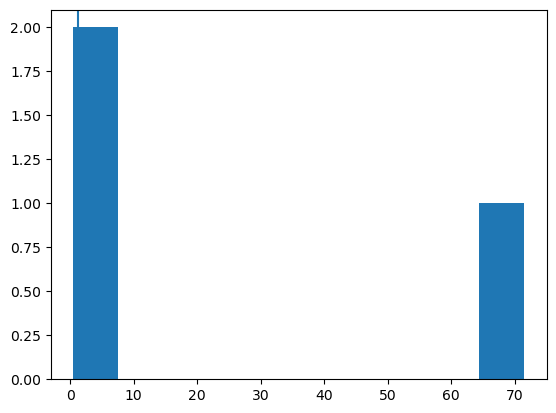

In [396]:
plt.hist(ksiestimator[:,0])
plt.axvline(ksi[0])
plt.show()

In [401]:
def MHprecision(N, n, T, epsilon, randomstate) :
    
    time0 = time.time()
    
    #Génération des données observées
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    X = genX(n, T, mu, sigma)
    
    #Génération de l'état initial
    ksiMH = [np.abs(np.random.standard_cauchy(2))]
    sigmaMH = [np.random.wald(ksiMH[0][0], ksiMH[0][1], n)]
    
    #Génération de la chaîne de Markov
    i = 0
    while (np.linalg.norm(ksi-ksiMH[i]) > epsilon) & (i < N) :
        L = 1
    
        #Génération des propositions
        ksiMHprop = [np.random.exponential(scale=ksiMH[i][0]), np.random.exponential(scale=ksiMH[i][1])]
        sigmaMHprop = []
        for k in range(n) :
            sigmaMHprop.append(np.random.exponential(scale=sigmaMH[i][k]))
        Lprop = 1
        
        for j in range(n):
    
            AMH = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMH = sigmaMH[i][j]*(AMH@AMH.T)
    
            L = L*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMH)
            L = L*scipy.stats.invgauss.pdf(sigmaMH[i][j], mu=ksiMH[i][0]/ksiMH[i][1], loc=0, scale=ksiMH[i][1])
    
            AMHprop = np.eye(T, T+2) + mu[j][0]*np.eye(T, T+2,1) + mu[j][1]*np.eye(T, T+2,2)
            AMHprop = sigmaMHprop[j]*(AMHprop@AMHprop.T)
                
            Lprop = Lprop*scipy.stats.multivariate_normal.pdf(X[j], mean=np.zeros(T), cov=AMHprop)
            Lprop = Lprop*scipy.stats.invgauss.pdf(sigmaMHprop[j], mu=ksiMHprop[0]/ksiMHprop[1], loc=0, scale=ksiMHprop[1])
    
        L = L*scipy.stats.halfcauchy.pdf(ksiMH[i][0])*scipy.stats.halfcauchy.pdf(ksiMH[i][1])
        Lprop = Lprop*scipy.stats.halfcauchy.pdf(ksiMHprop[0])*scipy.stats.halfcauchy.pdf(ksiMHprop[1])
    
        num = 1
        den = 1
        for k in range(n) :
            num = num*scipy.stats.expon.pdf(sigmaMH[i][k], scale=sigmaMHprop[k])
            den = den*scipy.stats.expon.pdf(sigmaMHprop[k], scale=sigmaMH[i][k])
        num = num*scipy.stats.expon.pdf(ksiMH[i][0], scale=ksiMHprop[0])*scipy.stats.expon.pdf(ksiMH[i][1], scale=ksiMHprop[1])
        den = den*(scipy.stats.expon.pdf(ksiMHprop[0], scale=ksiMH[i][0])*scipy.stats.expon.pdf(ksiMHprop[1], scale=ksiMH[i][1]))
        num = num*Lprop
        den = den*L
        if den == 0 :  
            ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
            sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)
            #ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
            #sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
        else :
            r = min(1, num/den)
            if np.random.uniform() <= r:
                ksiMH = np.concatenate((ksiMH,[ksiMHprop]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMHprop]), axis=0)
            else : 
                ksiMH = np.concatenate((ksiMH,[ksiMH[i]]), axis=0)
                sigmaMH = np.concatenate((sigmaMH, [sigmaMH[i]]), axis=0)

        i+=1
            
    meanksiMH = [np.mean(ksiMH[:, 0]), np.mean(ksiMH[:, 1])]
    meansigmaMH = []
    for j in range(n) :
        meansigmaMH.append(np.mean(sigmaMH[:, j]))
            
    time1 = time.time()
    
    return(sigmaMH[-1], meansigmaMH, ksiMH[-1], meanksiMH, i, time1-time0)

In [403]:
MHprecision(100, 10, 20, 1, 0)

(array([0.09155383, 0.08446557, 0.08898268, 0.09557033, 0.09734332,
        0.10089846, 0.08967367, 0.09646141, 0.0963099 , 0.09135252]),
 [0.09155383392975834,
  0.0844655654826067,
  0.08898268268078856,
  0.09557032819689093,
  0.09734331611910357,
  0.10089845699521643,
  0.08967367006001778,
  0.09646140720278536,
  0.09630990109706863,
  0.09135251981854267],
 array([ 0.09258241, 44.77245044]),
 [0.09258241219829502, 44.77245044370263],
 100,
 1.6207871437072754)

In [55]:
def probmu2(x, u, v) :
  if (x<-1) | (x>1) :
    return(0)
  else :
    return(2*(((x+1)/2)**(u-1))*((1-(x+1)/2)**(v-1))/beta(u,v))

In [178]:
def Normpdf(X, mean, cov) :
    y =  np.exp(
            (-1/2)*np.dot((X[0]-mean), np.dot(np.linalg.inv(A),(X[0]-mean)))
                         )
    y = y/np.linalg.det(A)**(1/2)
    y = y/(2*np.pi)**(len(X[0])/2)
    
    return(y)